# AAE 451 Preliminary Sizing

In [187]:
from typing import Callable

import numpy as np
import pandas as pd
import scipy.constants as consts
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patheffects, patches
from tqdm.contrib import tzip

plt.close('all')

%matplotlib widget

In [188]:
# Define constants
RHO = 1.225  # kg / m^3

# Define design space
# Gross takeoff mass
GTOM_MIN = 8 * consts.lb
GTOM_MID = 10 * consts.lb
GTOM_MAX = 12 * consts.lb

# Takeoff launch velocity
V_TO_MIN = 10. * consts.foot
V_TO_MAX = 20. * consts.foot

# Define minimum and maximum values for aspect ratio
AR_MIN = 3
AR_MAX = 10

# Potentially unreasonable bounds on TWR
TWR_MIN = 0.5
TWR_MAX = 1.5

# Linear ranges of values
GTOM = np.array([GTOM_MID,])
V_TO = np.linspace(V_TO_MIN, V_TO_MAX, 5)
AR = np.linspace(AR_MIN, AR_MAX, 30)
TWR = np.linspace(TWR_MIN, TWR_MAX, 30)

# Mesh design space
GTOMw, V_TOx, ARy, TWRz = np.meshgrid(GTOM, V_TO, AR, TWR, indexing='ij')

# Define requirements
MAX_WINGSPAN = 5 * consts.foot

MAX_LENGTH = 60 * consts.inch

V_STALL = 35 * consts.foot

# Launch parameters
STARTING_ALT = 2.0 # meters
MIN_CLEARANCE_ALT = 1.0 # meters

INIT_FLIGHTPATH_ANGLE = np.deg2rad(15)

# Define assumptions
# Maximum lift coefficient
CL_MAX_CONS = 1.0
CL_MAX_LOW  = 1.2
CL_MAX_HIGH = 1.4
CL_MAX_AGGR = 1.8

# Zero-lift drag coefficient
CD0_CONS = 0.05
CD0_AGGR = 0.025

# Oswald efficiency factor
E_FACTOR_CONS = 0.70
E_FACTOR_AGGR = 0.85

Wing loading ($W/S$) is calculated using the lift equation assuming the balance of lift and weight. $W = mg = L = C_L \frac{1}{2}\rho V^2 S$. Dividing out by wing area $S$ yields $W/S = C_L \frac{1}{2}\rho V^2$.

In [189]:
WS = (CL_MAX_LOW * 0.5 * RHO * (V_STALL)**2)

print(f"Wing loading = {WS / consts.g:.2f} [kg/m²]; {WS / (consts.lbf / consts.foot**2):.2f} [lbf/ft²]")

Wing loading = 8.53 [kg/m²]; 1.75 [lbf/ft²]


In [190]:
S = (consts.g * GTOM_MID / WS)
mgc = S / MAX_WINGSPAN
AR_est = MAX_WINGSPAN**2 / S
print(f"Wing area = {S / consts.foot**2:.1f} [ft²]")
print(f"Mean Geometric Chord = {mgc / consts.foot:.1f} [ft]")
print(f"Aspect Ratio = {AR_est:.1f}")

Wing area = 5.7 [ft²]
Mean Geometric Chord = 1.1 [ft]
Aspect Ratio = 4.4


In [191]:
AR_TARGET = 5.
S_TARGET = MAX_WINGSPAN**2 / AR_TARGET
W_TARGET = (CL_MAX_LOW * 0.5 * RHO * V_STALL**2 * S_TARGET)

print(f"Target Weight = {W_TARGET / consts.lbf:.1f} [lbf]")

Target Weight = 8.7 [lbf]


Takeoff sizing is... tricky. Our takeoff is going to have to involve a bit of a loft followed by acceleration to stall speed, because our takeoff speed would require insanely low wing loading to stall at that speed.

Let's start by estimating what a realistic stall speed would be as a function of aspect ratio. Assuming SLUF (steady, level, unaccelerating flight), $L=W=mg$, where $L$ is lift, $W$ is weight, $m$ is mass, and $g$ is standard gravitational acceleration. Using the lift coefficient equation, $L=C_L q S$ where the dynamic pressure $q \equiv \frac{1}{2}\rho u^2$, $C_L$ is the aircraft lift coefficient, $S$ is the wing area, $\rho$ is the air density, and $u$ is the flight speed. Aspect ratio is defined as $AR \equiv b^2 / S$, where $b$  is the wingspan. Solving for flight speed in $mg = C_L \frac{1}{2}\rho u^2 S$, we get $u = \sqrt{2mg/C_L S}$, or $u = \sqrt{2mg \cdot AR /C_L b^2}$. If we assume that $C_L = C_{L\text{,max}}$ in our stall constraint condition, we can find $u_\text{stall}$.

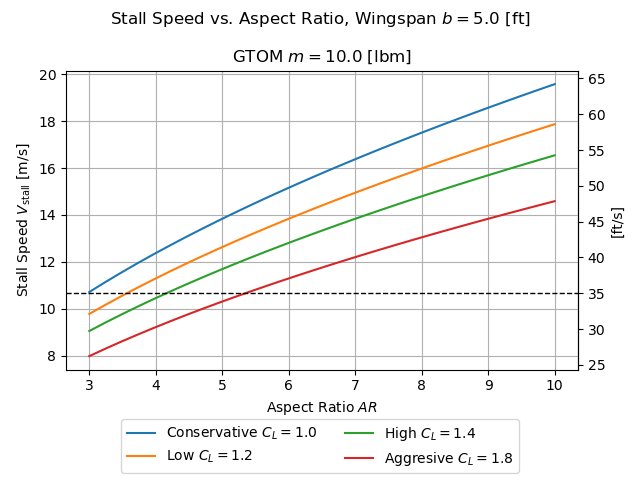

In [250]:
def calc_stall_speed(m, AR, b, CL_max):
    return np.sqrt(2. * m * consts.g * AR / (CL_max * b**2))

V_stall_cons = calc_stall_speed(GTOMw, ARy, MAX_WINGSPAN, CL_MAX_CONS)
V_stall_low = calc_stall_speed(GTOMw, ARy, MAX_WINGSPAN, CL_MAX_LOW)
V_stall_high = calc_stall_speed(GTOMw, ARy, MAX_WINGSPAN, CL_MAX_HIGH)
V_stall_aggr = calc_stall_speed(GTOMw, ARy, MAX_WINGSPAN, CL_MAX_AGGR)

fig, ax = plt.subplots(1,len(GTOMw), sharex=True, sharey=True, figsize=(6.4*(.5 + len(GTOMw)/2), 4.8), squeeze=False)

m2ft = lambda x: x / consts.foot
ft2m = lambda x: x * consts.foot

for k, GTOMi in enumerate(GTOM):
    l1 = ax[0,k].plot(AR, V_stall_cons[k, 0, :, 0], label=f"Conservative $C_L = {CL_MAX_CONS}$")
    l2 = ax[0,k].plot(AR, V_stall_low[k, 0, :, 0], label=f"Low $C_L = {CL_MAX_LOW}$")
    l3 = ax[0,k].plot(AR, V_stall_high[k, 0, :, 0], label=f"High $C_L = {CL_MAX_HIGH}$")
    l4 = ax[0,k].plot(AR, V_stall_aggr[k, 0, :, 0], label=f"Aggresive $C_L = {CL_MAX_AGGR}$")
    
    ax[0,k].set_xlabel("Aspect Ratio $AR$")
    ax[0,k].set_ylabel("Stall Speed $V_\\text{stall}$ [m/s]")

    secax = ax[0,k].secondary_yaxis('right', functions=(m2ft, ft2m))
    secax.set_ylabel('[ft/s]')
    if k < len(GTOMw) - 1:
        secax.set_yticklabels([])
    
    ax[0,k].set_title(f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    ax[0,k].grid()
    ax[0,k].axhline(V_STALL, linestyle="--", color="k", lw=1.)

fig.suptitle(f"Stall Speed vs. Aspect Ratio, Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft]")


fig.legend(handles=[*l1, *l2, *l3, *l4], loc="lower center", ncols=2)
fig.tight_layout(rect=(0, 0.1, 1, 1))
fig.savefig("stall_speed.png", dpi=300)

For a sanity check, plot the wing loading versus aspect ratio. Wing loading is $W/S = W \cdot AR / b^2$.

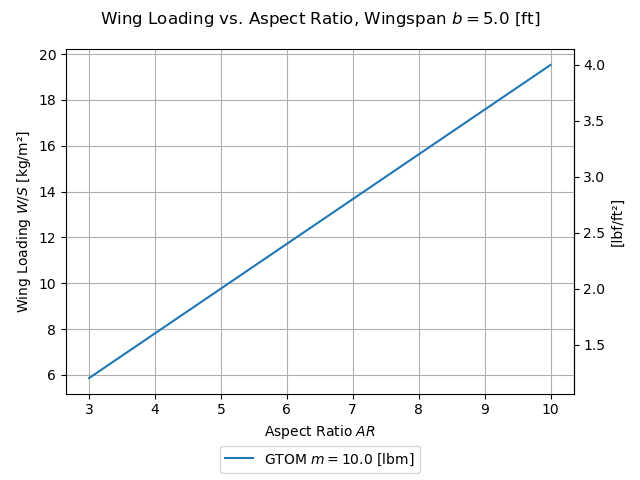

In [193]:
W_S = GTOMw * ARy / MAX_WINGSPAN**2

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6.4, 4.8))

kg_m2_2_lbf_ft2 = lambda x: x / (consts.lb / consts.foot**2)
lbf_ft2_2_kg_m2 = lambda x: x * (consts.lb / consts.foot**2)

for k, GTOMi in enumerate(GTOM):
    ax.plot(AR, W_S[k, 0, :, 0], label=f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    
ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Wing Loading $W/S$ [kg/m²]")

secax = ax.secondary_yaxis('right', functions=(kg_m2_2_lbf_ft2, lbf_ft2_2_kg_m2))
secax.set_ylabel('[lbf/ft²]')
ax.grid()

fig.suptitle(f"Wing Loading vs. Aspect Ratio, Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft]")

fig.legend(loc="lower center", ncols=3)
fig.tight_layout(rect=(0, 0.05, 1, 1))

fig.savefig("wing_loading.png", dpi=300)

We now need to pick a reasonable value from this plot based on realistic aspect ratios and stall speeds. A realistic aspect ratio is probably in the range of 4 on the low end, up to 8 on the high end. These would correspond with mean geometric chords for the wings calculated as follows:

In [194]:
AR_lo = 4
AR_hi = 8

mgc_min_AR = MAX_WINGSPAN / AR_MIN
mgc_lo_AR = MAX_WINGSPAN / AR_lo
mgc_hi_AR = MAX_WINGSPAN / AR_hi
mgc_max_AR = MAX_WINGSPAN / AR_MAX

print(f"Mean Geom. Chord (Min  AR = {AR_MIN:2}) = {mgc_min_AR:.2f} m ; {mgc_min_AR / consts.foot:.2f} ft ; {mgc_min_AR / consts.inch:.2f} in")
print(f"Mean Geom. Chord (Low  AR = {AR_lo:2}) = {mgc_lo_AR:.2f} m ; {mgc_lo_AR / consts.foot:.2f} ft ; {mgc_lo_AR / consts.inch:.2f} in")
print(f"Mean Geom. Chord (High AR = {AR_hi:2}) = {mgc_hi_AR:.2f} m ; {mgc_hi_AR / consts.foot:.2f} ft ; {mgc_hi_AR / consts.inch:.2f} in")
print(f"Mean Geom. Chord (Max  AR = {AR_MAX:2}) = {mgc_max_AR:.2f} m ; {mgc_max_AR / consts.foot:.2f} ft ; {mgc_max_AR / consts.inch:.2f} in")

Mean Geom. Chord (Min  AR =  3) = 0.51 m ; 1.67 ft ; 20.00 in
Mean Geom. Chord (Low  AR =  4) = 0.38 m ; 1.25 ft ; 15.00 in
Mean Geom. Chord (High AR =  8) = 0.19 m ; 0.62 ft ; 7.50 in
Mean Geom. Chord (Max  AR = 10) = 0.15 m ; 0.50 ft ; 6.00 in


We can add an "eye test" to visualize what these look like.

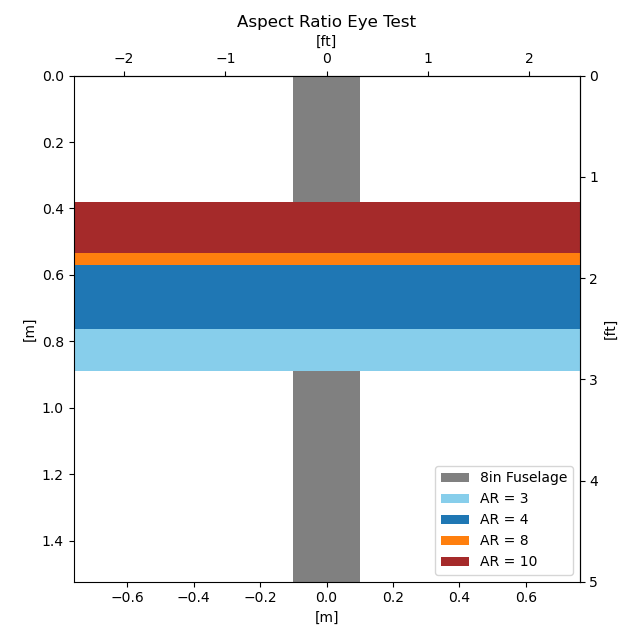

In [195]:
fig, ax = plt.subplots(1,1, figsize=(6.4,6.4))

ax.set_xlim(-MAX_WINGSPAN/2, MAX_WINGSPAN/2)
ax.set_ylim(0, MAX_LENGTH)
ax.set_aspect('equal')
ax.invert_yaxis()

fuselage = patches.Rectangle((-4 * consts.inch, 0), 8 * consts.inch, MAX_LENGTH, facecolor='gray', label="8in Fuselage")
wing_min_AR = patches.Rectangle((-MAX_WINGSPAN / 2, MAX_LENGTH * 0.25), MAX_WINGSPAN, mgc_min_AR, facecolor='skyblue', label=f"AR = {AR_MIN}")
wing_lo_AR = patches.Rectangle((-MAX_WINGSPAN / 2, MAX_LENGTH * 0.25), MAX_WINGSPAN, mgc_lo_AR, facecolor='C0', label=f"AR = {AR_lo}")
wing_hi_AR = patches.Rectangle((-MAX_WINGSPAN / 2, MAX_LENGTH * 0.25), MAX_WINGSPAN, mgc_hi_AR, facecolor='C1', label=f"AR = {AR_hi}")
wing_max_AR = patches.Rectangle((-MAX_WINGSPAN / 2, MAX_LENGTH * 0.25), MAX_WINGSPAN, mgc_max_AR, facecolor='brown', label=f"AR = {AR_MAX}")

ax.add_patch(fuselage)
ax.add_patch(wing_min_AR)
ax.add_patch(wing_lo_AR)
ax.add_patch(wing_hi_AR)
ax.add_patch(wing_max_AR)

ax.legend(handles=[fuselage, wing_min_AR, wing_lo_AR, wing_hi_AR, wing_max_AR], loc="lower right")

secaxx = ax.secondary_xaxis('top', functions=(m2ft, ft2m))
secaxy = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
secaxx.set_xlabel('[ft]')
secaxy.set_ylabel('[ft]')

ax.set_title("Aspect Ratio Eye Test")
fig.tight_layout()
fig.savefig("eye_test.png", dpi=300)

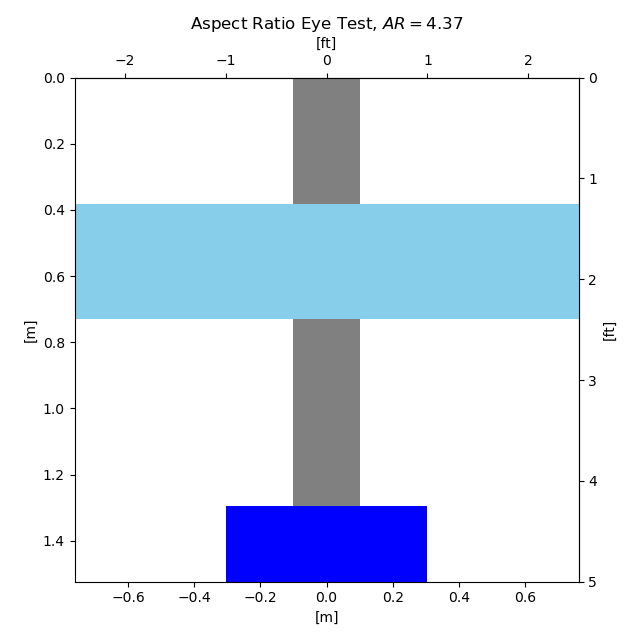

In [196]:
fig, ax = plt.subplots(1,1, figsize=(6.4,6.4))

ax.set_xlim(-MAX_WINGSPAN/2, MAX_WINGSPAN/2)
ax.set_ylim(0, MAX_LENGTH)
ax.set_aspect('equal')
ax.invert_yaxis()

fuselage = patches.Rectangle((-4 * consts.inch, 0), 8 * consts.inch, MAX_LENGTH, facecolor='gray', label="8in Fuselage")
wing = patches.Rectangle((-MAX_WINGSPAN / 2, MAX_LENGTH * 0.25), MAX_WINGSPAN, mgc, facecolor='skyblue', label=f"AR = {AR_est:.2f}")
tail = patches.Rectangle((-0.2*MAX_WINGSPAN, MAX_LENGTH*0.85), MAX_WINGSPAN*0.4, MAX_LENGTH*0.15, facecolor='blue', label=f"Tail")

ax.add_patch(fuselage)
ax.add_patch(wing)
ax.add_patch(tail)

# ax.legend(handles=[fuselage, wing_min_AR, wing_lo_AR, wing_hi_AR, wing_max_AR], loc="lower right")

secaxx = ax.secondary_xaxis('top', functions=(m2ft, ft2m))
secaxy = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
secaxx.set_xlabel('[ft]')
secaxy.set_ylabel('[ft]')

ax.set_title(f"Aspect Ratio Eye Test, $AR = {AR_est:.2f}$")
fig.tight_layout()
# fig.savefig("eye_test.png", dpi=300)

Whatever we pick for aspect ratio or stall speed, we will need a propultion system that can accelerate the vehicle to that speed from the launch speed before it hits the ground. We can solve this as a relatively simple dynamics problem.

Initially, we're going to assume the vehicle is launched at some initial flightpath angle at the launch speed, so it has some inital vertical and horiziontal velocity components. It will start from a certain vertical height, and begin falling due to gravity. Let's assume a starting height and a minimum acceptable height so we don't impact the ground. During this time, the vehicle accelerates under thrust from the launch speed. As the vehicle accelerates, it generates increasing lift proportional to its airspeed squared according to the lift equation. Simultaneously, drag increases on the vehicle as lift and velocity increase. A free body diagram describing the problem is shown below:

<!-- ![Takeoff Dynamics](takeoff_dynamics.png) -->

The dynamical equations are as follows:

$$\begin{align*}
\dot{u} &= \frac{T}{m}\cos\left(\alpha_{C_L\text{max}} + \gamma\right) - \frac{L}{m}\sin\gamma - \frac{D}{m}\cos\gamma\\
\dot{w} &= g - \frac{T}{m}\sin\left(\alpha_{C_L\text{max}} + \gamma\right) - \frac{L}{m}\cos\gamma + \frac{D}{m}\sin\gamma\\
u(0) &= V_{TO} \cos \gamma_0\\
w(0) &= -V_{TO} \sin \gamma_0
\end{align*}$$

Where $u$ is horizontal velocity, $w$ is vertical velocity (positive down), $g$ is gravitational acceleration, $m$ is mass, $L$ is lift, $D$ is drag, $T$ is thrust, $V_{TO}$ is the launch velocity, $\gamma$ is the flightpath angle (satisfying $\tan\gamma = -w/u$), and $\alpha_{C_L\text{max}}$ is the angle of attack at stall. This value $\alpha_{C_L\text{max}}$ may be estimated using the relation $C_L = C_{L\alpha}\left(\alpha - \alpha_0\right)$, where $\alpha_0$ depends on flap deployment (and is zero with no flaps deployed), and $C_{L\alpha} = 2\pi$ for a theoretical infinite airfoil, but 3D effects reduce this value; for a finite elliptical wing, $C_{L\alpha} = \frac{2\pi}{1+2/AR}$. Lift is found using the lift equation and the stall lift coefficient: $L = \frac{1}{2}\rho V^2 \frac{b^2}{AR} C_{L\text{,max}}$, where $V=\sqrt{u^2 + w^2}$. Similarly, drag $D = \frac{1}{2}\rho V^2 \frac{b^2}{AR} C_{D}$. The drag coefficient is $C_D = C_{D0} + \frac{C_{L\text{,max}}^2}{\pi AR e}$, where $e$ is the Oswald efficiency factor.

These equations could potentially be simplified to solve for some friendly relation, preferably in terms of wing and power loading for compatibility with other constraints. However, since computational power is so cheap, we can solve these equations numerically to simulate the launch dynamics over a design space of aspect ratio and thrust-to-weight ratio $TWR \equiv T/mg$.

In [197]:
# Initial conditions
AOA0_FLAPS = 0

# ODE system
def odefunc(t, y, AR, TWR, m, b, CL_max, AoA0, CD0, e_factor):
    x, z, u, w = y
    
    V = np.sqrt(u**2 + w**2)
    phi = np.atan2(-w, u)
    
    CL_alpha = 2*np.pi # / (1 + 2 / AR)
    alpha_CLmax = CL_max / CL_alpha + AoA0
    CD = CD0 + CL_max**2 / (np.pi * AR * e_factor)
    
    T_m = TWR * consts.g
    
    q = 0.5 * RHO * V**2
    S = b**2 / AR
    L_m = q * S * CL_max / m
    D_m = q * S * CD / m
    
    du_dt = T_m * np.cos(alpha_CLmax + phi) - L_m * np.sin(phi) - D_m * np.cos(phi) 
    dw_dt = consts.g - T_m * np.sin(alpha_CLmax + phi) - L_m * np.cos(phi) + D_m * np.sin(phi)
    
    dy_dt = np.array([u, w, du_dt, dw_dt])
    return dy_dt

In [198]:
# ODE solver arguments
t_span = (0., 10.)

# When critical altitude is crossed
def event_threshold(t, y, AR, TWR, m, b, CL_max, AoA0, CD0, e_factor):
    return y[1] + MIN_CLEARANCE_ALT
event_threshold.direction = 1. # Only trigger on increasing (altitude down)

# When aircraft begins climbing
def event_success(t, y, AR, TWR, m, b, CL_max, AoA0, CD0, e_factor):
    return y[3]
event_success.terminal = True
event_success.direction = -1. # Only trigger on decreasing (negative = up)

# When aircraft altitude equals zero
def event_crash(t, y, AR, TWR, m, b, CL_max, AoA0, CD0, e_factor):
    return y[1]
event_crash.terminal = True

# When aircraft flight path exceeds initial flightpath angle
def event_loop(t, y, AR, TWR, m, b, CL_max, AoA0, CD0, e_factor):
    return np.atan2(-y[3], y[2]) - INIT_FLIGHTPATH_ANGLE
event_loop.terminal = True
event_loop.direction = +1. # Only trigger on increasing

events = [event_threshold, event_success, event_crash, event_loop]

y0 = np.array([0.0, -STARTING_ALT, np.cos(INIT_FLIGHTPATH_ANGLE) * V_TO_MAX, -np.sin(INIT_FLIGHTPATH_ANGLE) * V_TO_MAX])
args = (5, 0.95, GTOM_MAX, MAX_WINGSPAN, CL_MAX_CONS, AOA0_FLAPS, CD0_CONS, E_FACTOR_CONS)
sol = solve_ivp(odefunc, t_span, y0, events=events, args=args, rtol=1e-10, atol=1e-10)

sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  3.015e-03 ...  1.242e+00  1.262e+00]
        y: [[ 0.000e+00  1.779e-02 ...  1.388e+01  1.421e+01]
            [-2.000e+00 -2.005e+00 ... -1.545e+00 -1.544e+00]
            [ 5.888e+00  5.912e+00 ...  1.645e+01  1.659e+01]
            [-1.578e+00 -1.565e+00 ...  1.167e-01  1.665e-16]]
      sol: None
 t_events: [array([], dtype=float64), array([ 1.262e+00]), array([], dtype=float64), array([], dtype=float64)]
 y_events: [array([], dtype=float64), array([[ 1.421e+01, -1.544e+00,  1.659e+01,  1.665e-16]]), array([], dtype=float64), array([], dtype=float64)]
     nfev: 254
     njev: 0
      nlu: 0

In [199]:
# Solve ODE over design space
sols = np.empty_like(GTOMw, dtype=object)
u_reached = np.full_like(GTOMw, np.nan)
min_alt = np.full_like(GTOMw, np.nan)

ndenn = np.ndenumerate

for (idx, GTOMi), (_, V_TOj), (_, ARk), (_, TWRl) in tzip(ndenn(GTOMw), ndenn(V_TOx), ndenn(ARy), ndenn(TWRz), total=GTOMw.size):
    args = (ARk, TWRl, GTOMi, MAX_WINGSPAN, CL_MAX_CONS, AOA0_FLAPS, CD0_CONS, E_FACTOR_CONS)
    
    y0 = np.array([0.0, -STARTING_ALT, np.cos(INIT_FLIGHTPATH_ANGLE) * V_TOj, -np.sin(INIT_FLIGHTPATH_ANGLE) * V_TOj])
    sol = solve_ivp(odefunc, t_span, y0, events=events, args=args, rtol=1e-10, atol=1e-10)
    
    sols[idx] = sol
    if len(sol.t_events[0]):
        u_reached[idx] = sol.y_events[0][0,2]
    elif len(sol.t_events[2]):
        u_reached[idx] = sol.y_events[1][0,2]
    # elif len(sol.t_events[3]):
    #     u_reached[idx] = sol.y_events[3][0,2]
    # else:
    #     u_reached[idx] = sol.y[-1,2]
        
    if len(sol.t_events[1]):
        min_alt[idx] = -sol.y_events[1][0,1]
    elif len(sol.t_events[2]):
        min_alt[idx] = 0.
    elif len(sol.t_events[3]):
        min_alt[idx] = -sol.y_events[3][0,1]


  0%|          | 0/4500 [00:00<?, ?it/s]

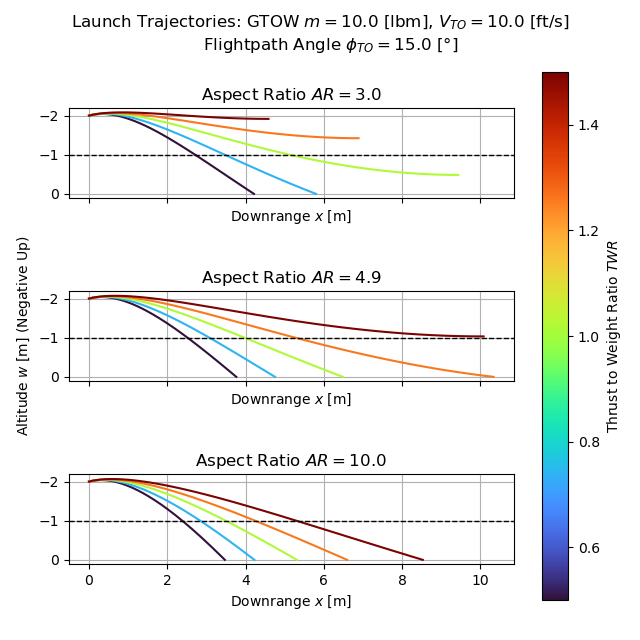

In [200]:
fig, ax = plt.subplots(3,1, squeeze=False, sharex=True, sharey=True, figsize=(6.4, 6.4))

norm = mpl.colors.Normalize(vmin=TWR[0], vmax=TWR[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['turbo'])
cmap.set_array([])

i, j = 0, 0

for idx, k in enumerate([0, 8, len(AR) - 1]):
    for l in [0, len(TWR)//4, len(TWR)//2, 3*len(TWR)//4, len(TWR) - 1]:
        sol = sols[i, j, k, l]
        ax[idx,0].plot(sol.y[0], sol.y[1], color=cmap.to_rgba(TWR[l]))
    ax[idx,0].invert_yaxis()
    ax[idx,0].set_aspect('equal')
    ax[idx,0].grid()
    ax[idx,0].set_title(f"Aspect Ratio $AR = {AR[k]:.1f}$")
    ax[idx,0].set_xlabel("Downrange $x$ [m]")
    ax[idx,0].axhline(-MIN_CLEARANCE_ALT, linestyle='--', color='k', linewidth=1.0)

ax[1,0].set_ylabel("Altitude $w$ [m] (Negative Up)")

fig.suptitle(f"Launch Trajectories: GTOW $m = {GTOM[i]/consts.lb}$ [lbm], $V_{{TO}} = {V_TO[j]/consts.foot}$ [ft/s]\n\
    Flightpath Angle $\phi_{{TO}} = {np.rad2deg(INIT_FLIGHTPATH_ANGLE):.1f}$ [°]")
fig.tight_layout()

cbar = fig.colorbar(cmap, ax=ax)
cbar.ax.set_ylabel("Thrust to Weight Ratio $TWR$")

fig.savefig("trajectories.png", dpi=300)

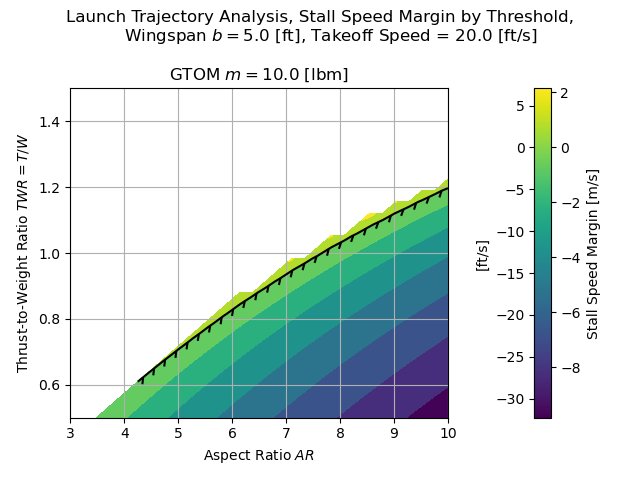

In [201]:
fig, ax = plt.subplots(1,len(GTOMw), sharex=True, sharey=True, figsize=(6.4*(.5 + len(GTOMw)/2), 4.8), squeeze=False)

l = -1

norm = mpl.colors.Normalize(vmin=np.nanmin(u_reached[:,l] - V_stall_cons[:,l]), vmax=np.nanmax(u_reached[:,l] - V_stall_cons[:,l]))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['viridis'])
cmap.set_array([])

for k, GTOMi in enumerate(GTOM):
    ax[0,k].contourf(ARy[k,l], TWRz[k,l], u_reached[k,l] - V_stall_cons[k,l], norm=norm)
    t = ax[0,k].contour(ARy[k,l], TWRz[k,l], u_reached[k,l] - V_stall_cons[k,l], [0], colors='k')
    t.set(path_effects=[patheffects.withTickedStroke(angle=45, length=0.5)])
    
    ax[0,k].set_xlabel("Aspect Ratio $AR$")
    ax[0,k].set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
    
    ax[0,k].set_title(f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    ax[0,k].grid()

fig.suptitle(f"Launch Trajectory Analysis, Stall Speed Margin by Threshold,\n\
    Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft], Takeoff Speed = {V_TO[l] / consts.foot} [ft/s]")

fig.tight_layout(rect=(0, 0, 1, 1))
cbar = fig.colorbar(cmap, ax=ax)
cbar.ax.set_ylabel("Stall Speed Margin [m/s]")
secax = cbar.ax.secondary_yaxis('left', functions=(m2ft, ft2m))
secax.set_ylabel("[ft/s]")
fig.subplots_adjust(right=0.7)

fig.savefig("stall_margin_example.png", dpi=300)

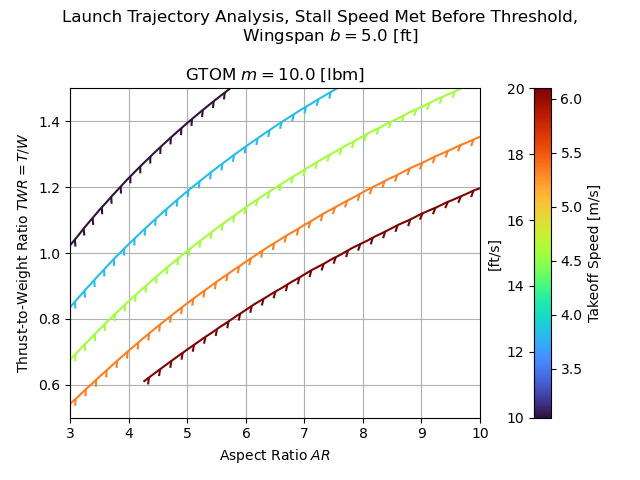

In [202]:
fig, ax = plt.subplots(1,len(GTOMw), sharex=True, sharey=True, figsize=(6.4*(.5 + len(GTOMw)/2), 4.8), squeeze=False)

norm = mpl.colors.Normalize(vmin=V_TO_MIN, vmax=V_TO_MAX)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['turbo'])
cmap.set_array([])

for k, GTOMi in enumerate(GTOM):
    for l, V_TOj in enumerate(V_TO):
        t = ax[0,k].contour(ARy[k,l], TWRz[k,l], u_reached[k,l] - V_stall_cons[k,l], [0], colors=[cmap.to_rgba(V_TOj)])
        t.set(path_effects=[patheffects.withTickedStroke(angle=45, length=0.5)])
    
    ax[0,k].set_xlabel("Aspect Ratio $AR$")
    ax[0,k].set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
    
    ax[0,k].set_title(f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    ax[0,k].grid()

fig.suptitle(f"Launch Trajectory Analysis, Stall Speed Met Before Threshold,\n\
    Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft]")

fig.tight_layout(rect=(0, 0, 1, 1))
cbar = fig.colorbar(cmap, ax=ax)
cbar.ax.set_ylabel("Takeoff Speed [m/s]")
secax = cbar.ax.secondary_yaxis('left', functions=(m2ft, ft2m))
secax.set_ylabel("[ft/s]")
fig.subplots_adjust(right=0.75)

fig.savefig("stall_margin.png", dpi=300)

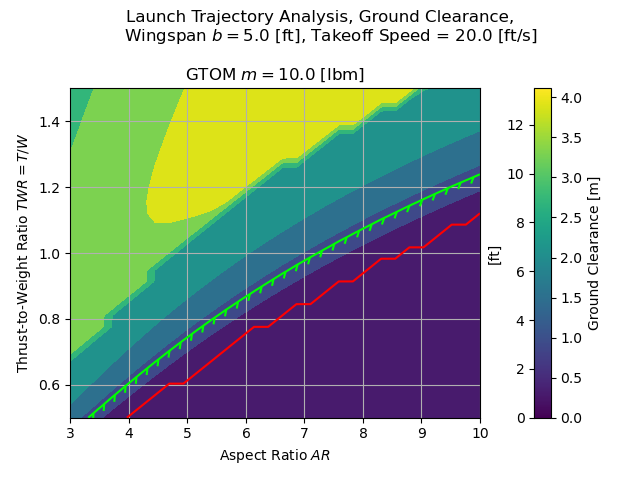

In [203]:
fig, ax = plt.subplots(1,len(GTOMw), sharex=True, sharey=True, figsize=(6.4*(.5 + len(GTOMw)/2), 4.8), squeeze=False)

l = -1

norm = mpl.colors.Normalize(vmin=np.nanmin(min_alt[:,l]), vmax=np.nanmax(min_alt[:,l]))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['viridis'])
cmap.set_array([])

for k, GTOMi in enumerate(GTOM):
    ax[0,k].contourf(ARy[k,l], TWRz[k,l], min_alt[k,l], norm=norm)
    ax[0,k].contour(ARy[k,l], TWRz[k,l], min_alt[k,l], [0], colors='r')
    t = ax[0,k].contour(ARy[k,l], TWRz[k,l], min_alt[k,l], [MIN_CLEARANCE_ALT], colors='lime')
    t.set(path_effects=[patheffects.withTickedStroke(angle=45, length=0.5)])
    
    ax[0,k].set_xlabel("Aspect Ratio $AR$")
    ax[0,k].set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
    
    ax[0,k].set_title(f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    ax[0,k].grid()

fig.suptitle(f"Launch Trajectory Analysis, Ground Clearance,\n\
    Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft], Takeoff Speed = {V_TO[l] / consts.foot} [ft/s]")

fig.tight_layout(rect=(0, 0, 1, 1))
cbar = fig.colorbar(cmap, ax=ax)
cbar.ax.set_ylabel("Ground Clearance [m]")
secax = cbar.ax.secondary_yaxis('left', functions=(m2ft, ft2m))
secax.set_ylabel("[ft]")
fig.subplots_adjust(right=0.75)

fig.savefig("ground_clearance_example.png", dpi=300)

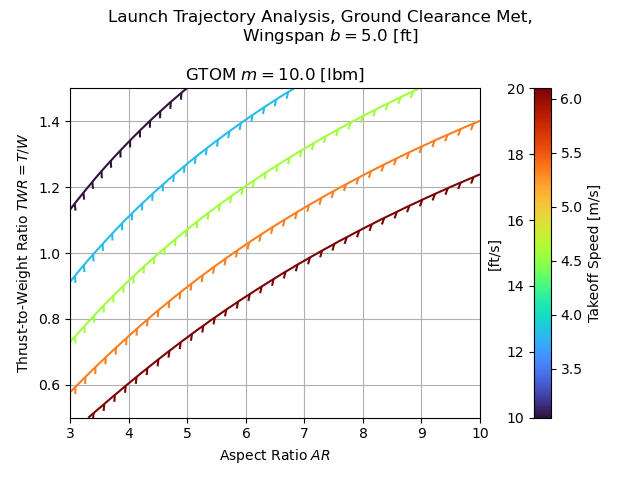

In [204]:
fig, ax = plt.subplots(1,len(GTOMw), sharex=True, sharey=True, figsize=(6.4*(.5 + len(GTOMw)/2), 4.8), squeeze=False)

norm = mpl.colors.Normalize(vmin=V_TO_MIN, vmax=V_TO_MAX)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['turbo'])
cmap.set_array([])

for k, GTOMi in enumerate(GTOM):
    for l, V_TOj in enumerate(V_TO):
        t = ax[0,k].contour(ARy[k,l], TWRz[k,l], min_alt[k,l], [MIN_CLEARANCE_ALT], colors=[cmap.to_rgba(V_TOj)])
        t.set(path_effects=[patheffects.withTickedStroke(angle=45, length=0.5)])
    
    ax[0,k].set_xlabel("Aspect Ratio $AR$")
    ax[0,k].set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
    
    ax[0,k].set_title(f"GTOM $m = {GTOMi / consts.lb}$ [lbm]")
    ax[0,k].grid()

fig.suptitle(f"Launch Trajectory Analysis, Ground Clearance Met,\n\
    Wingspan $b = {MAX_WINGSPAN / consts.foot}$ [ft]")

fig.tight_layout(rect=(0, 0, 1, 1))
cbar = fig.colorbar(cmap, ax=ax)
cbar.ax.set_ylabel("Takeoff Speed [m/s]")
secax = cbar.ax.secondary_yaxis('left', functions=(m2ft, ft2m))
secax.set_ylabel("[ft/s]")
fig.subplots_adjust(right=0.75)

fig.savefig("ground_clearance.png", dpi=300)

## Constraint Diagrams

In [225]:
# Requirements
R_TURN = 200 * consts.foot
CLIMB_RATE = 400 * consts.foot / consts.minute
ALTITUDE = 200 * consts.foot

LAP_STRAIGHT = 600 * consts.foot
NUM_LAPS = 3

# Design points
DESIGN_AR = 4
V_STALL = 35 * consts.foot
V_CRUISE = 70 * consts.foot
V_TURN = 65 * consts.foot
V_CLIMB = 55 * consts.foot

# Assumptions
L_D_MAX = 6
CLIMB_L_D_SCALE = 0.866
TURN_L_D_SCALE = 0.900
ETA_PROP = 0.6
ETA_MOTOR = 0.7
ENRG_DENSITY = 150 * consts.hour
NUM_CELLS = 4
CELL_VOLTS = 3.7

# Derived
K_FACTOR = 1. / (np.pi * DESIGN_AR * E_FACTOR_CONS)
CLIMB_ANGLE = np.asin(CLIMB_RATE / V_CLIMB)
LOAD_FACTOR = np.sqrt((V_TURN**2 / R_TURN / consts.g)**2 + 1)
BANK_ANGLE = np.acos(1 / LOAD_FACTOR)
BATT_VOLTS = NUM_CELLS * CELL_VOLTS

print(f"Climb angle      = {np.rad2deg(CLIMB_ANGLE):.2f}°")
print(f"Turn load factor = {LOAD_FACTOR:.3f}")
print(f"Turn bank angle  = {np.rad2deg(BANK_ANGLE):.1f}°")

Climb angle      = 6.96°
Turn load factor = 1.196
Turn bank angle  = 33.3°


In [226]:
def mk_stall_cond_func(
    CL_max: float, vs: float, rho: float = RHO
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make stall condition constraint function.

    :param float CL_max: Maximum lift coefficient
    :param float vs: Stall true airspeed
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (CL_max * rho * vs**2 * 0.5) - ws

    return f

In [227]:
def mk_cruise_cond_func(
    vc: float, CD_0: float, eta_p: float, rho: float = RHO, CD_scale: float = 1.1
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vc: Cruise true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float rho: (optional) Atmospheric density
    :param float CD_scale: (optional) Scale factor for total drag (including induced drag)
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p * 2.) / (rho * vc**3 * CD_scale * CD_0) * ws - wp

    return f

In [228]:
def mk_climb_cond_func(
    vcl: float, gamma: float, eta_p: float, L_D_max: float, L_D_scale: float = CLIMB_L_D_SCALE
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vcl: Climb true airspeed
    :param float gamma: Climb rate
    :param float eta_p: Propeller efficiency
    :param float L_D_max: Maximum lift-to-drag ratio L/D
    :param float L_D_scale: (optional) Scale factor for L/D ration during climb
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return eta_p / vcl / (gamma + 1 / (L_D_max * L_D_scale)) - wp

    return f

In [229]:
def mk_turn_cond_func(
    vtr: float, CD_0: float, eta_p: float, n: float, k: float, rho: float = RHO,
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vtr: Turn true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float n: Turn load factor
    :param float k: Induced drag factor 1 / π AR e
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """
    
    q = 0.5 * rho * vtr**2

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p / q / vtr / (k * (n / q)**2 * ws + CD_0 / ws)) - wp

    return f

In [230]:
stall_f = mk_stall_cond_func(CL_MAX_HIGH, V_STALL)
cruise_f = mk_cruise_cond_func(V_CRUISE, CD0_CONS, ETA_PROP)
climb_f = mk_climb_cond_func(V_CLIMB, CLIMB_ANGLE, ETA_PROP, L_D_MAX)
turn_f = mk_turn_cond_func(V_TURN, CD0_CONS, ETA_PROP, LOAD_FACTOR, K_FACTOR)

In [231]:
WING_LOADING_MIN= 0.1 * (consts.lbf / consts.foot**2)
WING_LOADING_MAX= 2.5 * (consts.lbf / consts.foot**2)
POWER_LOADING_MIN = consts.g / 200 # 200 W/kg -> N/W
POWER_LOADING_MAX = consts.g / 50 # 50 W/kg -> N/W

ws = np.linspace(WING_LOADING_MIN, WING_LOADING_MAX)
wp = np.linspace(POWER_LOADING_MIN, POWER_LOADING_MAX)

wsx, wpy = np.meshgrid(ws, wp)

stall_const = stall_f(wsx, wpy)
cruise_const = cruise_f(wsx, wpy)
climb_const = climb_f(wsx, wpy)
turn_const = turn_f(wsx, wpy)

In [232]:
DESIGN_WS = 1.8 * (consts.lbf / consts.foot**2)
DESIGN_WP = consts.g / 100 # 100 W/kg -> N/W

C:\Users\ekessel\AppData\Local\Temp\ipykernel_38192\544240876.py:10: RuntimeWarning: divide by zero encountered in divide
  yconv_from = lambda y: (1 / y) * consts.g / (consts.lbf / consts.horsepower)


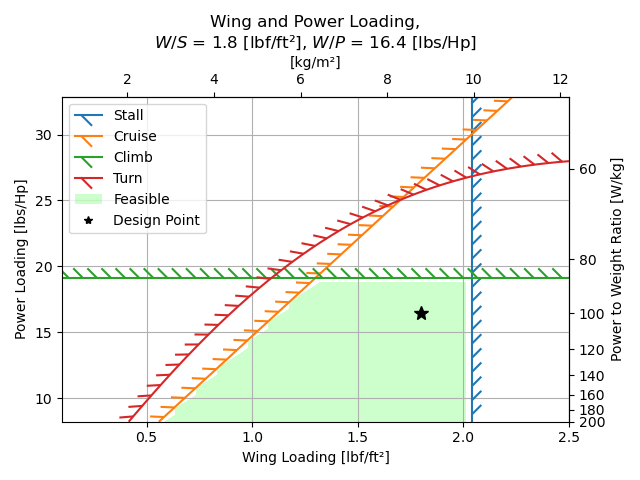

In [233]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)

ws_lbf_ft2 = wsx / (consts.lbf / consts.foot**2)
wp_lbf_hp = wpy / (consts.lbf / consts.horsepower)

xconv_to = lambda x: x * (consts.lb / consts.foot**2)
xconv_from = lambda x: x / (consts.lb / consts.foot**2)

yconv_to = lambda y: 1 / (y * (consts.lbf / consts.horsepower) / consts.g)
yconv_from = lambda y: (1 / y) * consts.g / (consts.lbf / consts.horsepower)

mask = np.full_like(ws_lbf_ft2, np.nan)
mask[
    (stall_const > 0)
    & (cruise_const > 0)
    & (climb_const > 0)
    & (turn_const > 0)
] = 0.
ax.contourf(ws_lbf_ft2, wp_lbf_hp, mask, colors='lime', alpha=.2)

stall_cntr = ax.contour(ws_lbf_ft2, wp_lbf_hp, stall_const, [0], colors="C0", linestyles="-")
stall_cntr.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])

cruise_cntr = ax.contour(ws_lbf_ft2, wp_lbf_hp, cruise_const, [0], colors="C1", linestyles="-")
cruise_cntr.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])

climb_cntr = ax.contour(ws_lbf_ft2, wp_lbf_hp, climb_const, [0], colors="C2", linestyles="-")
climb_cntr.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])

turn_cntr = ax.contour(ws_lbf_ft2, wp_lbf_hp, turn_const, [0], colors="C3", linestyles="-")
turn_cntr.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])

saxx = ax.secondary_xaxis('top', functions=(xconv_to, xconv_from))
saxy = ax.secondary_yaxis('right', functions=(yconv_to, yconv_from))
# saxy.set_yticks(np.linspace(POWER_LOADING_MIN / consts.g, POWER_LOADING_MAX / consts.g, 6))

ax.plot(DESIGN_WS / (consts.lbf / consts.foot**2), DESIGN_WP / (consts.lbf / consts.horsepower), '*k', markersize=10)

l0 = plt.Line2D([], [], color='C0', label="Stall")
l0.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])
l1 = plt.Line2D([], [], color='C1', label="Cruise")
l1.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])
l2 = plt.Line2D([], [], color='C2', label="Climb")
l2.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])
l3 = plt.Line2D([], [], color='C3', label="Turn")
l3.set(path_effects=[patheffects.withTickedStroke(angle=-45, length=1.0)])

legend_lines = [
    l0, l1, l2, l3,
    patches.Patch(facecolor='lime', alpha=.2, label="Feasible"),
    plt.Line2D([], [], color='k', linestyle='', marker='*', label="Design Point"),
]
ax.legend(handles=legend_lines, loc="upper left")
ax.set_xlabel("Wing Loading [lbf/ft²]")
ax.set_ylabel("Power Loading [lbs/Hp]")
saxx.set_xlabel("[kg/m²]")
saxy.set_ylabel("Power to Weight Ratio [W/kg]")

ax.set_title(f"Wing and Power Loading,\n$W/S$ = {DESIGN_WS / (consts.lbf / consts.foot**2):.1f} \
[lbf/ft²], $W/P$ = {DESIGN_WP / (consts.lbf / consts.horsepower):.1f} [lbs/Hp]")
fig.tight_layout()

ax.grid()
fig.savefig("constraint_diagram.png", dpi=300)

In [234]:
def predict_specific_energy_level_flight(dist: float, L_D_cruise: float) -> float:
    """
    Predict the specific energy consumed during level flight

    :param float dist: Level flight distance range
    :param float L_D_cruise: L/D lift to drag ratio in level flight
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g / L_D_cruise

In [235]:
def predict_specific_energy_turn_flight(
    dist: float, L_D_turn: float, load_factor: float
) -> float:
    """
    Predict the specific energy consumed during turning flight

    :param float dist: Turning flight distance range
    :param float L_D_turn: L/D lift to drag ratio in level flight
    :param float load_factor: Turn load factor
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g * load_factor / L_D_turn

In [217]:
def predict_specific_energy_climb(
    altitude: float, L_D_climb: float, climb_angle: float
) -> float:
    """
    Predict the specific energy consumed during climb phase

    :param float altitude: Total altitude of climb
    :param float L_D_climb: L/D lift to drag ratio in level flight
    :param float climb_angle: Angle of climb
    :return float: Specific energy consumption E/m
    """

    return altitude * consts.g * (1 + 1 / (np.tan(climb_angle) * L_D_climb))

C:\Users\ekessel\AppData\Local\Temp\ipykernel_38192\544240876.py:10: RuntimeWarning: divide by zero encountered in divide
  yconv_from = lambda y: (1 / y) * consts.g / (consts.lbf / consts.horsepower)


In [218]:
def predict_specific_energy_total(
    dist_straight: float,
    turn_radius: float,
    climb_alt: float,
    L_D_max: float,
    load_factor: float,
    climb_angle: float,
    cruise_speed: float,
    turn_speed: float,
    climb_rate: float,
    num_laps: int = 1,
    L_D_factor_turn: float = TURN_L_D_SCALE,
    L_D_factor_climb: float = CLIMB_L_D_SCALE,
):
    """
    Predict the specific energy consumed during a mission and report a the
    the breakdowns. Assumes an oval racetrack path with a straightaway distance
    of `dist_straight` and semicircular caps with radius `turn_radius`, for a
    total oval length of `2 * dist_straight + 2*pi * turn_radius`. This is
    repeated `num_laps` times. A climb at `climb_angle` to an altitude of
    `climb_alt` preceedes the laps.

    :param float dist_straight: Straightaway distance of one half lap
    :param float turn_radius: Turn radius of lap
    :param float climb_alt: Altitude to climb to
    :param float L_D_max: Maximum lift-to-drag ratio L/D of aircraft
    :param float load_factor: Turn load factor
    :param float climb_angle: Climb rate angle
    :param float cruise_speed: Cruising speed for timing estimation
    :param float turn_speed: Turning speed for timing estimation
    :param float climb_rate: Climb vertical rate for timing estimation
    :param float num_laps: (optional) Number of laps in mission
    :param float L_D_factor_turn: (optional) Scale factor for L/D ration during turn
    :param float L_D_factor_climb: (optional) Scale factor for L/D ration during climb
    """

    lap_straight = 2 * dist_straight
    lap_turn = 2 * np.pi * turn_radius
    lap_total = lap_straight + lap_turn

    total_straight = lap_straight * num_laps
    total_turn = lap_turn * num_laps
    total_range = total_straight + total_turn

    L_D_straight = L_D_max
    L_D_turn = L_D_max * L_D_factor_turn
    L_D_climb = L_D_max * L_D_factor_climb

    e_straight_lap = predict_specific_energy_level_flight(lap_straight, L_D_straight)
    e_turn_lap = predict_specific_energy_turn_flight(lap_turn, L_D_turn, load_factor)
    e_lap = e_straight_lap + e_turn_lap
    
    e_straight_total = predict_specific_energy_level_flight(total_straight, L_D_straight)
    e_turn_total = predict_specific_energy_turn_flight(total_turn, L_D_turn, load_factor)
    e_total_laps = e_straight_total + e_turn_total
    
    e_climb = predict_specific_energy_climb(climb_alt, L_D_climb, climb_angle)
    
    e_total = e_climb + e_total_laps
    
    t_climb = climb_alt / climb_rate
    t_lap_straight = lap_straight / cruise_speed
    t_lap_turn = lap_turn / cruise_speed
    t_lap_total = t_lap_straight + t_lap_turn
    t_laps_total = t_lap_total * num_laps
    t_total = t_laps_total + t_climb*2

    return e_total, {
        "e_total": e_total,
        "e_climb": e_climb,
        "e_total_laps": e_total_laps,
        "e_straight_total": e_straight_total,
        "e_turn_total": e_turn_total,
        "e_lap": e_lap,
        "e_straight_lap": e_straight_lap,
        "e_turn_lap": e_turn_lap,
        "range_total": total_range,
        "range_straight": total_straight,
        "range_turn": total_turn,
        "range_lap": lap_total,
        "range_lap_straight": lap_straight,
        "range_lap_turn": lap_turn,
        "climb_alt": climb_alt,
        "L_D_straight": L_D_straight,
        "L_D_turn": L_D_turn,
        "L_D_climb": L_D_climb,
        "t_climb": t_climb,
        "t_lap_straight": t_lap_straight,
        "t_lap_turn": t_lap_turn,
        "t_lap_total": t_laps_total,
        "t_laps_total": t_laps_total,
        "t_total": t_total,
    }

In [219]:
energy, data = predict_specific_energy_total(LAP_STRAIGHT, R_TURN, ALTITUDE, L_D_MAX, LOAD_FACTOR, CLIMB_ANGLE, V_CRUISE, V_TURN, CLIMB_RATE, NUM_LAPS)

d = pd.DataFrame(data, index=[1])
d

,e_total,e_climb,e_total_laps,e_straight_total,e_turn_total,e_lap,e_straight_lap,e_turn_lap,range_total,range_straight,...,climb_alt,L_D_straight,L_D_turn,L_D_climb,t_climb,t_lap_straight,t_lap_turn,t_lap_total,t_laps_total,t_total
1,5829.806811,1539.998764,4289.808046,1793.440152,2496.367894,1429.936015,597.813384,832.122631,2246.348929,1097.28,...,60.96,6,5.4,5.196,30.0,17.142857,17.951958,105.284445,105.284445,165.284445


In [220]:
def estimate_battery_mass_fraction_props(
    e_total: float,
    eta_prop: float,
    eta_motor: float,
    battery_e_density: float,
    margin: float,
):
    """
    Estimate the battery mass fraction from other parameters.

    :param float e_total: Mission specific energy total
    :param float eta_prop: Propeller efficiency
    :param float eta_motor: Motor efficiency
    :param float battery_e_density: Battery energy density
    :param float margin: Energy margin
    """

    e_batt = e_total * margin / (eta_prop * eta_motor)
    mb_m = e_batt / battery_e_density

    return mb_m, {
        "mb/m": mb_m,
        "mission specific energy": e_total,
        "specific energy with margin": e_total * margin,
        "battery specific energy": e_batt,
    }

In [221]:
mb_m, mb_data = estimate_battery_mass_fraction_props(energy, ETA_PROP, ETA_MOTOR, ENRG_DENSITY, 2.5)

d2 = pd.DataFrame(mb_data, index=[1])
d2

,mb/m,mission specific energy,specific energy with margin,battery specific energy
1,0.064262,5829.806811,14574.517027,34701.231016


In [222]:
mb = mb_m * GTOM_MID

print(f"Battery estimated mass = {mb * 1000:.0f} [g]")

Battery estimated mass = 291 [g]


In [248]:
P_climb = data["e_climb"] * GTOM_MID / data["t_climb"] / ETA_MOTOR
P_laps = data["e_total_laps"] * GTOM_MID / data["t_lap_total"] / ETA_MOTOR
P_const = GTOM_MID * consts.g / DESIGN_WP

print(f"Power levels:")
print(f"Climb:      {P_climb:.1f} [W]")
print(f"Cruise:     {P_laps:.1f} [W]")
print(f"Constraint: {P_const:.1f} [W]")

Power levels:
Climb:      332.6 [W]
Cruise:     264.0 [W]
Constraint: 453.6 [W]


In [245]:
batt_enrg = mb_data["battery specific energy"] * GTOM_MID / ETA_MOTOR
capacity = batt_enrg / BATT_VOLTS
capacity_Ah = capacity / consts.hour

print(f"Battery energy: {batt_enrg:.0f} [J]; {batt_enrg / consts.hour:.1f} [Wh]")
print(f"Estimated battery capacity: {capacity_Ah * 1000:.0f} [mAh]")

Battery energy: 224860 [J]; 62.5 [Wh]
Estimated battery capacity: 4220 [mAh]


In [249]:
current_climb = P_climb / BATT_VOLTS
current_laps = P_laps / BATT_VOLTS
current_const = P_const / BATT_VOLTS

print(f"Discharge rates:")
print(f"Climb:      {current_climb:.1f} [A]; {current_climb/capacity_Ah:.1f} [C-factor]")
print(f"Cruise:     {current_laps:.1f} [A]; {current_laps/capacity_Ah:.1f} [C-factor]")
print(f"Constraint: {current_const:.1f} [A]; {current_const/capacity_Ah:.1f} [C-factor]")

Discharge rates:
Climb:      22.5 [A]; 5.3 [C-factor]
Cruise:     17.8 [A]; 4.2 [C-factor]
Constraint: 30.6 [A]; 7.3 [C-factor]
